# Projeto 2 – Sistemas Representados por Variáveis de Estado
Controle 2 2020/2

Aluno: Jhonatan de Freitas Lang


In [ ]:
pip install control

In [ ]:
import numpy as np
import sympy as sp
import control                   
import control.matlab
import math
import cmath
import matplotlib.pyplot as plt
from scipy import linalg

## Objetivos




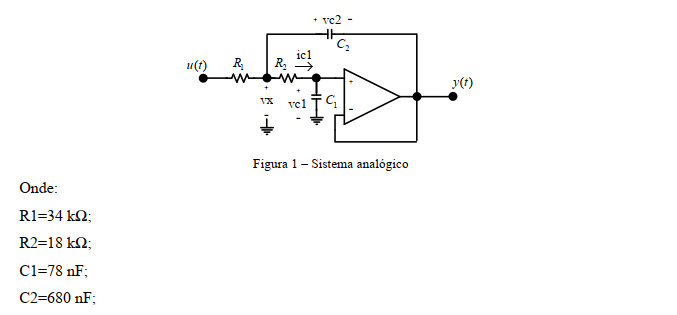

# Análise da planta

In [ ]:
# Declaração de variáveis

NT = len('jhonatandefreitaslang')
R1 = 34e3;
R2 = 18e3;
C1 = 78e-9;                
C2 = 680e-9;


# X1 = Vc1; X2 = Vx
A = np.block([[-1/(C1*R2), 1/(C1*R2)],[-1/(C1*R2) + 1/(C2*R2), 1/(C1*R2) - 1/(C2*R1) - 1/(C2*R2)]])
B = np.block([[ 0 ],[ 1/(C2*R1) ]])
#A = np.block([[0, 1/(C1*R2)],[-1/(R1*C2), (-R1-R2)/(R1*R2*C2)]])
#B = np.block([[1/(R1*C2)],[2/(C1*R1+C1*R2)]])
C = np.matrix('1, 0')
D = 0;

#conversão para função de transferência

# sistema no espaço de estados
sys = control.ss(A,B,C,D);

# convertendo para função de tranferência com a utilização da função ss2tf
G = control.ss2tf(sys);
[[n]],[[d]] = control.tfdata(G);

display("G:")
display(G)
display('A:')
display(A)
display('B:')
display(B)
display('NT:')
display(NT)

'G:'

TransferFunction(array([8.52651283e-14, 3.08066917e+04]), array([1.00000000e+00, 1.24951942e+02, 3.08066917e+04]))

'A:'

array([[-712.25071225,  712.25071225],
       [-630.55136585,  587.29877069]])

'B:'

array([[ 0.        ],
       [43.25259516]])

'NT:'

21

In [ ]:

# resposta para entrada ao degrau
Y, t_y = control.matlab.step(sys,0.15);

In [ ]:
max(Y)

1.3005975844643423

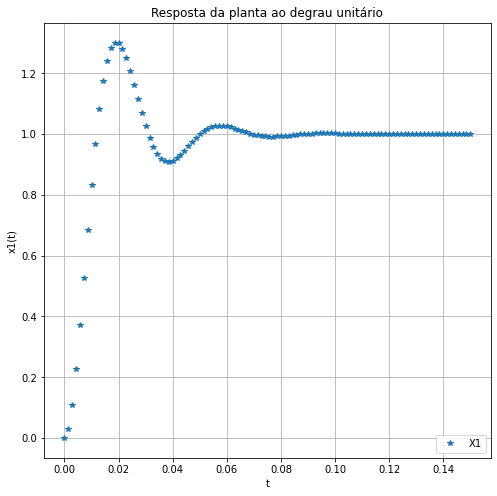

In [ ]:
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(8,8)

ax1.plot(t_y,Y,'*')
ax1.set_title("Resposta da planta ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1','X~1'],loc="lower right")
ax1.grid(True,'both')



In [ ]:
# Verificando polos da planta
autovalores_planta, autovetores = linalg.eig(A);
polos_planta = autovalores_planta
polos_planta

array([-62.47597078+164.02269593j, -62.47597078-164.02269593j])

 ### A planta possui um par de polos complexos conjugados em "-62.47597078 +- 164.02269593j"




# Controlador


 ### **Especificações Mínimas da resposta ao degrau (*)**

Degrau de referência de 1,0 V a 1,5 V;

Ts5% = 21 (ms);

Erro nulo em regime permanente para resposta ao degrau;

MP = 16 (%);

Estabilidade 


Defindo o ganho de retroação -K do controlador e aplicando a retroalimentação.

In [ ]:
Ts5 = len('jhonatandefreitaslang') *1e-3
Mp = len('jhonatan')*2/100

# Adotando 10 vezes como escolha, temos Ts = Ts5/10 = 21ms/10 = 2.1ms
Ts = Ts5/10
Fs = 1/Ts

# cálculo dos novos parâmetros de frequência e fator de amortecimento
zeta = math.sqrt(math.log(Mp)**2/(math.log(Mp)**2 + math.pi**2))
wn = 3/(zeta*(Ts5))
wd = wn*math.sqrt(1-(zeta**2))
ws = 2*math.pi/Ts

ws_wd_relation = ws/wd

# Polos dominantes desejados

s1 = -zeta*wn + 1j*wd
s2 = -zeta*wn - 1j*wd
s3 = -10*abs(s1);


In [ ]:
print(zeta)
print(wd)
print(wn)
print(Ts)
print(Fs)

0.5038681020461065
244.89986360271635
283.5209100894239
0.0021000000000000003
476.19047619047615


In [ ]:
# Matriz de Controlabilidade
Mc = control.ctrb(A,B)
Mc

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc) #número de postos do sistema
if len(Mc) == rank_Mc:          
    display("A matriz é completamente controlavel")

'A matriz é completamente controlavel'

In [ ]:
# Equação característica desejada
eq_des = np.poly([s1, s2, s3]);
eq_des

# Matrizes Expandidas
A_controle = np.block([[A, np.zeros([2,1])],[-C, 0]]);
B_controle = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_chapeu = [k1 k2 -ki]
K_controle = control.acker(A_controle,B_controle,[s1, s2, s3])
K_controle

K = np.block([K_controle[0,0], K_controle[0,1] ])
Ki = -K_controle[0,2]
AA = np.block([[A-B*K, B*Ki],[-C,0]])
BB = np.block([[0],[0],[1]])
CC = np.block([1, 0, 0])
DD = 0;

ctrld_sys = control.ss(AA,BB,CC,DD);


## **Item A - Simulação do controlador e planta**

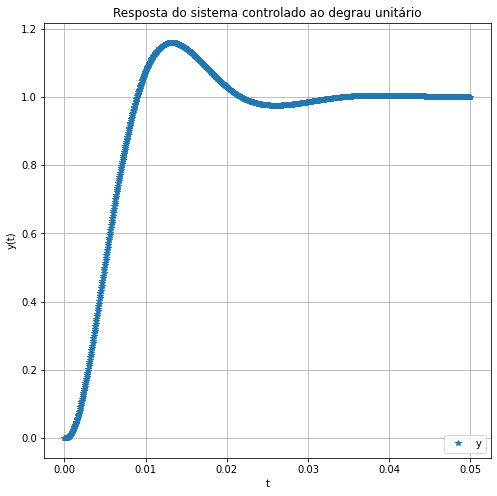

In [ ]:

# resposta para entrada ao degrau do sistema controlado
tfinal = 0.05
Y_ctrld, t_y_ctrld = control.matlab.step(ctrld_sys,tfinal);

fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(8,8)

ax1.plot(t_y_ctrld,Y_ctrld,'*')
ax1.set_title("Resposta do sistema controlado ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y'],loc="lower right")
ax1.grid(True,'both')


In [ ]:


# Sobressinal percentual
Mp = (max(Y_ctrld)-Y_ctrld[-1])/(Y_ctrld[-1]-Y_ctrld[0]);
print("\nMp medido = ",Mp)

# Tempo de acomodação para 5%

j = len(t_y_ctrld)-1;
delta = 0;
while (delta < 0.05):
    delta = abs((Y_ctrld[j]-Y_ctrld[-1])/Y_ctrld[-1]);
    ts = t_y_ctrld[j];
    j = j-1;
    
print("\n\n Ts 5% medido = \n",ts)


Mp medido =  0.15980502787376796


 Ts 5% medido = 
 0.019036027263875367


### equações recursivas

In [ ]:
print(Fs)
print(Fs*5)


476.19047619047615
2380.9523809523807


In [ ]:
# equações recursivas

#t = t_y_ctrld


Fs = Fs*10 #2500
Ts = 1/Fs
tfinal = 0.05;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);
r = np.ones(len(t));
r[0] = 0;

# declaração dos vetores
x1 = np.zeros(len(t));
x2 = np.zeros(len(t));
csi = np.zeros(len(t));

u = np.zeros(len(t));

x1_ponto = np.zeros(len(t));
x2_ponto = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
y = np.zeros(len(t));

y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0

for j in range(0,len(t)):
    # Equações dos integradores
    x1[j] = Ts*x1_ponto[j-1] + x1[j-1];
    x2[j] = Ts*x2_ponto[j-1] + x2[j-1];    
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];

    # Equação da lei de controle
    u[j] = -(K[0]*x1[j] + K[1]*x2[j]) + Ki*csi[j];

    # Equação diferencial de estados:  Xponto=A*X+B*U
    x1_ponto[j] = A[0,0]*x1[j] + A[0,1]*x2[j] + B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j] + A[1,1]*x2[j] + B[1]*u[j]; 

    # Equação de Saída: Y=C*X+D*U
    y[j] = C[0,0]*x1[j]# + C[1]*x2[j]# + D*u[j];

    # Equação de erro
    csi_ponto[j] = r[j] - y[j];

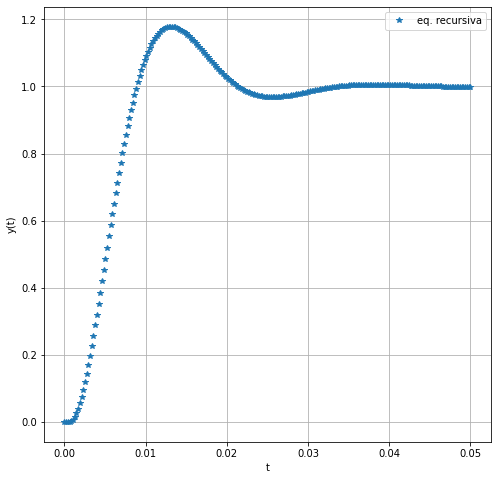

In [ ]:
# comportamento da saída y                      
fig = plt.figure()
fig.set_size_inches(8,8)
plt.plot( t, y,'*')#t_y_ctrld, Y_ctrld,'-')#
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(['eq. recursiva'],loc="upper right")
plt.grid(True)
plt.show()

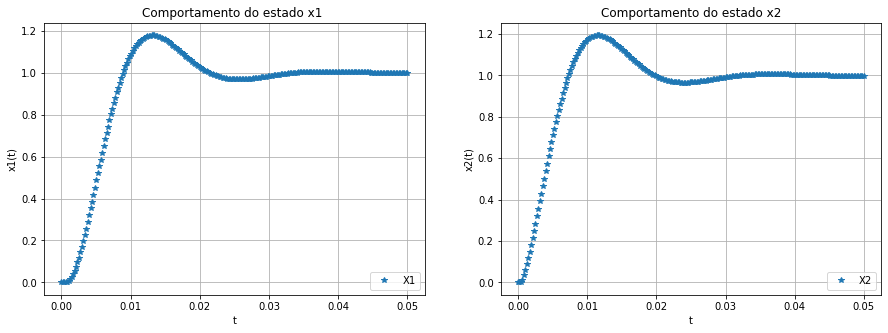

In [ ]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(15,5)

ax1.plot(t, x1,'*')
ax1.set_title("Comportamento do estado x1 ")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2,'*')
ax2.set_title("Comportamento do estado x2")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2'],loc="lower right")
ax2.grid(True)

# Observador de ordem plena



In [ ]:
# Matriz de observabilidade
Ac=np.conjugate(np.transpose(A))
Cc=np.conjugate(np.transpose(C))

N = np.block([Cc,Ac*Cc]);
                           
# teste de observabilidade
rank_Mo = np.linalg.matrix_rank(N)   

if len(N) == rank_Mo:          
    display("A matriz é completamente observável")

'A matriz é completamente observável'

In [ ]:
# Verificando polos da planta
autovalores_planta, autovetores = linalg.eig(A);

# Polos desejados para o observador, escolhidos de modo que o observador tenha o dobro da velocidade do controlador
s1_obs = -2*abs(s1)
s2_obs = -2*abs(s2)

display("Polos do observador:")
display(s1_obs)
display(s2_obs)

'Polos do observador:'

-567.0418201788478

-567.0418201788478

In [ ]:
# Matriz de Ganhos do Observador
Ke = np.transpose(control.acker(np.transpose(A),np.transpose(C),[s1_obs, s2_obs]))
Ke

matrix([[1009.1316988 ],
        [1240.28172257]])

In [ ]:
# Verificando polos do observador
autovalores_observador, autovetores = linalg.eig(A-Ke*C)
autovalores_observador

array([-567.04182018+0.j, -567.04182018+0.j])

In [ ]:
# Verificação através do sistema expandido

AA = np.block([[A, np.zeros([len(A),len(A)])],[Ke*C, A-Ke*C]]);
BB = np.block([[B],[B]]);
CC = np.eye(2*len(A));
DD = np.zeros([2*len(A),1])

obs_sys = control.ss(AA,BB,CC,DD);

## **Item B - Simulação do observador e planta**

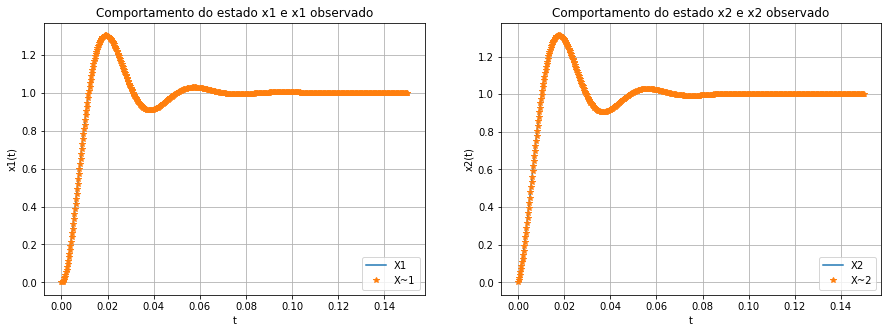

In [ ]:
# resposta para entrada ao degrau
Y_obs, t_y_obs = control.matlab.step(obs_sys,0.15);

# separando os elemntos do vetor X
x1 = Y_obs[:,0];
x2 = Y_obs[:,1];
x1e = Y_obs[:,2];
x2e = Y_obs[:,3];


fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(15,5)

ax1.plot(t_y_obs, x1, t_y_obs, x1e,'*')
ax1.set_title("Comportamento do estado x1 e x1 observado")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1','X~1'],loc="lower right")
ax1.grid(True)

ax2.plot(t_y_obs, x2, t_y_obs, x2e,'*')
ax2.set_title("Comportamento do estado x2 e x2 observado")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2','X~2'],loc="lower right")
ax2.grid(True)


### equações recursivas

In [ ]:
# declaração dos vetores



#Fs = 1000
#Ts = 1/Fs
tfinal = 0.15;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);


u = np.ones(len(t+10));

# vetores de estados
x1_rec = np.zeros(len(t));
x2_rec = np.zeros(len(t));
x1_ponto_rec = np.zeros(len(t));
x2_ponto_rec = np.zeros(len(t));

# vetor de saída Y = C*X
y = np.zeros(len(t));

# vetores do observador de estatos
til_x1_rec = np.zeros(len(t));
til_x2_rec = np.zeros(len(t));
til_x1_ponto_rec = np.zeros(len(t));
til_x2_ponto_rec = np.zeros(len(t));

til_x1_ponto_rec[0]=B[0]*u[0];
til_x2_ponto_rec[0]=B[1]*u[0];

til_y = np.zeros(len(t));

# Equações da lei de controle
erro_1 = np.zeros(len(t));
erro_2 = np.zeros(len(t));

for j in range(0,Kmax-5):
    # Equações dos integradores
    x1_rec[j] = Ts*x1_ponto_rec[j-1] + x1_rec[j-1];
    x2_rec[j] = Ts*x2_ponto_rec[j-1] + x2_rec[j-1];
    til_x1_rec[j] = Ts*til_x1_ponto_rec[j-1] + til_x1_rec[j-1]
    til_x2_rec[j] = Ts*til_x2_ponto_rec[j-1] + til_x2_rec[j-1]
    
    # Equação de Saída: Y=C*X
    y[j] = C[0,0]*x1_rec[j] + C[0,1]*x2_rec[j];


    # Equação de Saída do observador : tilY=C*tilX
    til_y[j] = C[0,0]*til_x1_rec[j] + C[0,1]*til_x2_rec[j];

    #Equações da lei de controle
    erro_1[j] = Ke[0]*(y[j] - til_y[j]);
    erro_2[j] = Ke[1]*(y[j] - til_y[j]);

    # Equação diferencial de estados de x_ponto e til_x_ponto
    x1_ponto_rec[j] = A[0,0]*x1_rec[j] + A[0,1]*x2_rec[j] + B[0]*u[j];
    x2_ponto_rec[j] = A[1,0]*x1_rec[j] + A[1,1]*x2_rec[j] + B[1]*u[j];
    til_x1_ponto_rec[j] = A[0,0]*til_x1_rec[j] + A[0,1]*til_x2_rec[j] + B[0]*u[j] + erro_1[j];
    til_x2_ponto_rec[j] = A[1,0]*til_x1_rec[j] + A[1,1]*til_x2_rec[j] + B[1]*u[j] + erro_2[j];


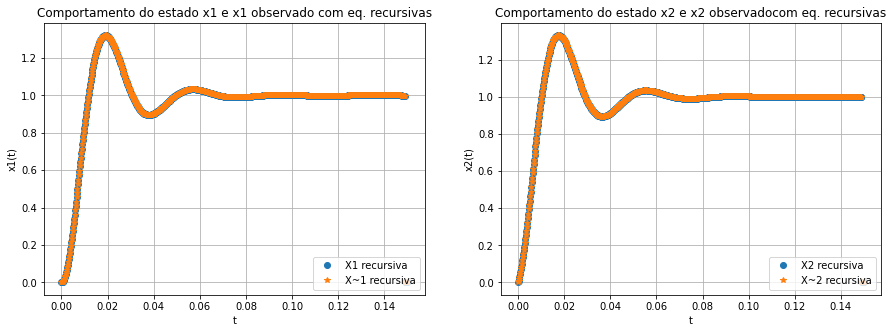

In [ ]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(15,5)

ax1.plot(t, x1_rec, 'o', t, til_x1_rec,'*')
ax1.set_title("Comportamento do estado x1 e x1 observado com eq. recursivas")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1 recursiva','X~1 recursiva'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2_rec, 'o', t, til_x2_rec,'*')
ax2.set_title("Comportamento do estado x2 e x2 observadocom eq. recursivas")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2 recursiva','X~2 recursiva'],loc="lower right")
ax2.grid(True)

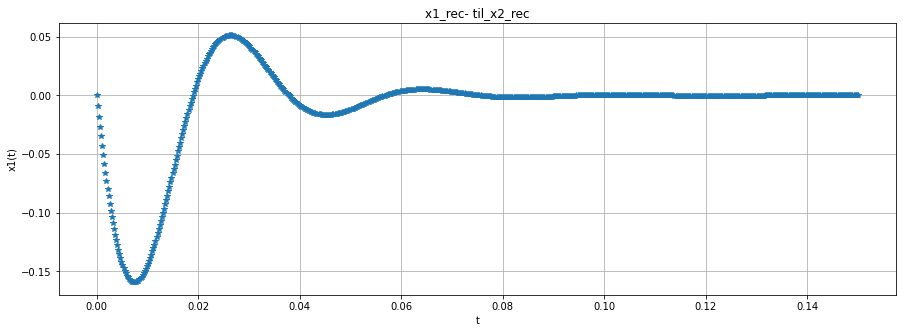

In [ ]:
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(15,5)

ax1.plot(t, x1_rec- til_x2_rec,'*')
ax1.set_title("x1_rec- til_x2_rec")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
#ax1.legend(['X1 recursiva','X~1 recursiva'],loc="lower right")
ax1.grid(True)

# Sistema completo com controlador, observador e planta

## **Item C - Simulação do sistema completo com controlador, observador e planta**

In [ ]:
print(Ki)
print(Ke[0])
print(Ke[1])
print("\n")
print(K)
print("\n")
print(A[1,0])
print("\n")
print(B)
print(C)
print(D)
print(Fs)

7397.930046147873
[[1009.1316988]]
[[1240.28172257]]


[-41.36262504  69.26685981]


-630.5513658454836


[[ 0.        ]
 [43.25259516]]
[[1 0]]
0
4761.9047619047615


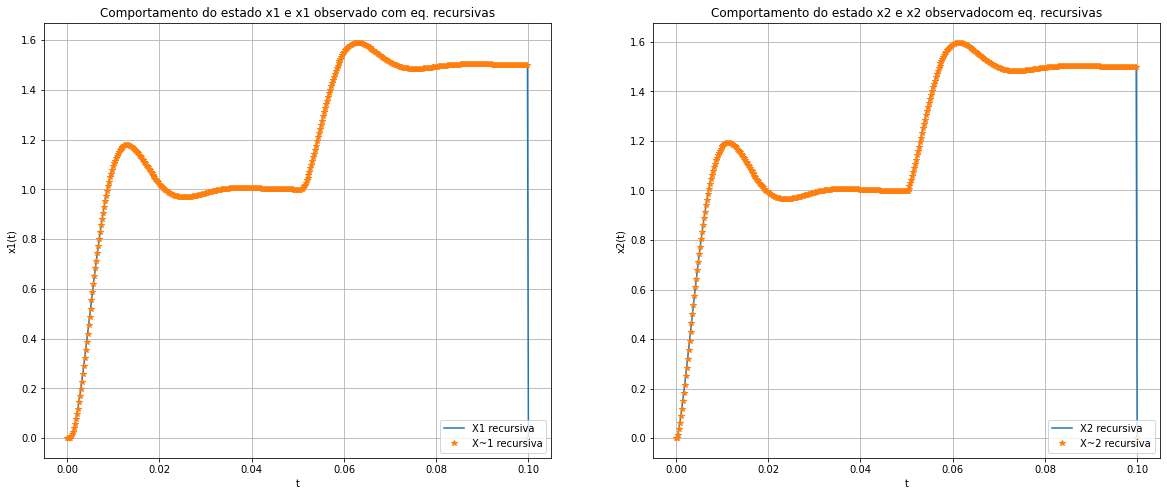

In [ ]:

tfinal = 0.1;
Kmax = int((tfinal/Ts)+1);
t =np.linspace(0, tfinal, Kmax);

r = np.ones(int(len(t)/2));
r = np.concatenate((r, 1.5*r), axis=0)

csi = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
u = np.zeros(len(t));

# vetores de estados
x1_rec = np.zeros(len(t));
x2_rec = np.zeros(len(t));
x1_ponto_rec = np.zeros(len(t));
x2_ponto_rec = np.zeros(len(t));

# vetor de saída Y = C*X
y = np.zeros(len(t));


# vetores do observador de estatos
til_x1_rec = np.zeros(len(t));
til_x2_rec = np.zeros(len(t));
til_x1_ponto_rec = np.zeros(len(t));
til_x2_ponto_rec = np.zeros(len(t));

til_y = np.zeros(len(t));


# Realimentação de controle do observador
erro_1 = np.zeros(len(t));
erro_2 = np.zeros(len(t));


## Condições iniciais

csi_ponto[0] = r[0] - y[0]; 

x1_ponto_rec[0] = A[0,0]*x1_rec[0] + A[0,1]*x2_rec[0] + B[0]*u[0];
x2_ponto_rec[0] = A[1,0]*x1_rec[0] + A[1,1]*x2_rec[0] + B[1]*u[0];
til_x1_ponto_rec[0]=B[0]*u[0];
til_x2_ponto_rec[0]=B[1]*u[0];


for j in range(0,Kmax-1):
    # sistema original
        # Equações dos integradores
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];
    x1_rec[j] = Ts*x1_ponto_rec[j-1] + x1_rec[j-1];
    x2_rec[j] = Ts*x2_ponto_rec[j-1] + x2_rec[j-1];

     # observador 
        # Equações dos integradores do observador
    til_x1_rec[j] = Ts*til_x1_ponto_rec[j-1] + til_x1_rec[j-1]
    til_x2_rec[j] = Ts*til_x2_ponto_rec[j-1] + til_x2_rec[j-1]
    
    # Equação de Saída: Y=C*X
    y[j] = C[0,0]*x1_rec[j];


    # Equação de erro
    csi_ponto[j] = r[j] - y[j];     


    # Equação da lei de controle
    u[j] = -(K[0]*til_x1_rec[j] + K[1]*til_x2_rec[j]) + Ki*csi[j];


        # Equação de Saída do observador : tilY=C*tilX
    til_y[j] = C[0,0]*til_x1_rec[j] + C[0,1]*til_x2_rec[j];

    #Equações da lei de controle
    erro_1[j] = Ke[0]*(y[j] - til_y[j]);
    erro_2[j] = Ke[1]*(y[j] - til_y[j]);


    # Equação diferencial de estados de x_ponto e til_x_ponto
    x1_ponto_rec[j] = A[0,0]*x1_rec[j] + A[0,1]*x2_rec[j] + B[0]*u[j];
    x2_ponto_rec[j] = A[1,0]*x1_rec[j] + A[1,1]*x2_rec[j] + B[1]*u[j];
    til_x1_ponto_rec[j] = A[0,0]*til_x1_rec[j] + A[0,1]*til_x2_rec[j] + B[0]*u[j] + erro_1[j];
    til_x2_ponto_rec[j] = A[1,0]*til_x1_rec[j] + A[1,1]*til_x2_rec[j] + B[1]*u[j] + erro_2[j];




fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(20,8)

ax1.plot(t, x1_rec, t, til_x1_rec,'*')
ax1.set_title("Comportamento do estado x1 e x1 observado com eq. recursivas")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1 recursiva','X~1 recursiva'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2_rec, t, til_x2_rec,'*')
ax2.set_title("Comportamento do estado x2 e x2 observadocom eq. recursivas")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2 recursiva','X~2 recursiva'],loc="lower right")
ax2.grid(True)

### Ação de controle

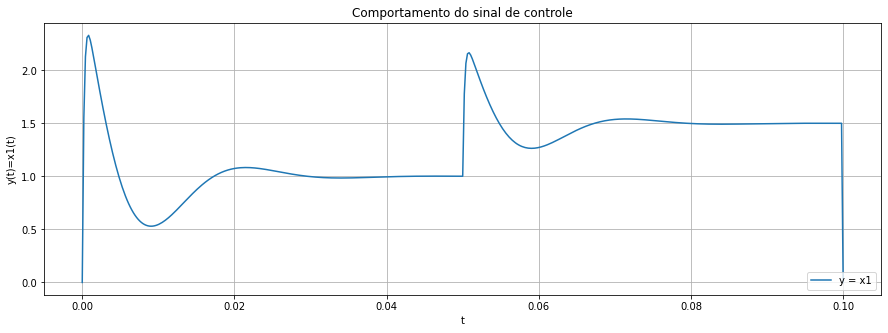

In [ ]:
# Ação de controle 
fig, (ax1 ) = plt.subplots(1, 1)
fig.set_size_inches(15,5)

ax1.plot(t,u)
ax1.set_title("Comportamento do sinal de controle")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)=x1(t)")
ax1.legend(['y = x1'],loc="lower right")
ax1.grid(True)

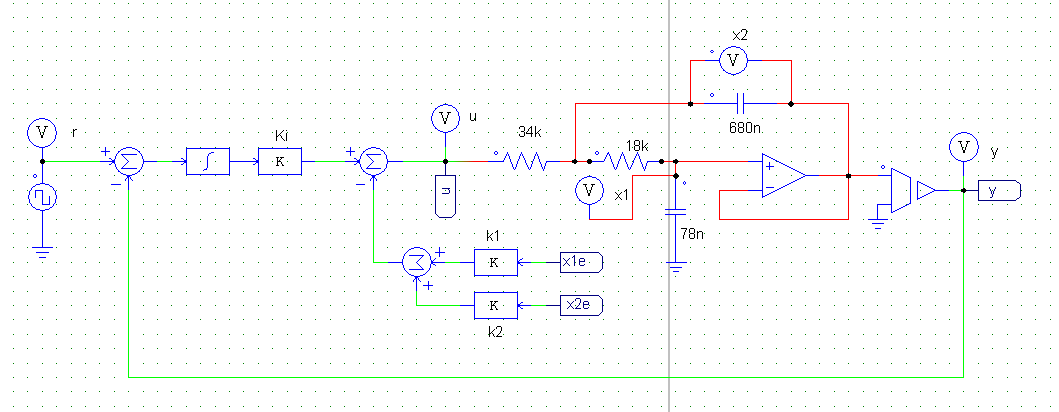

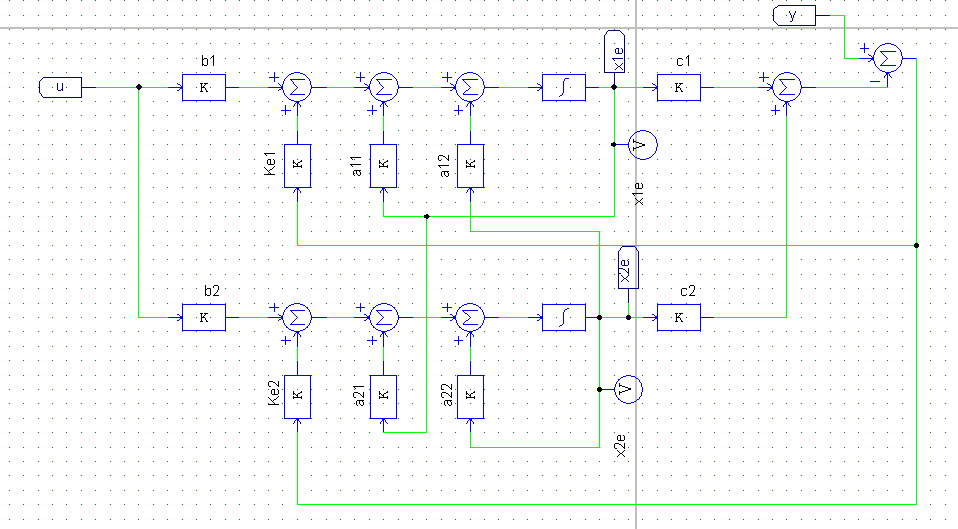

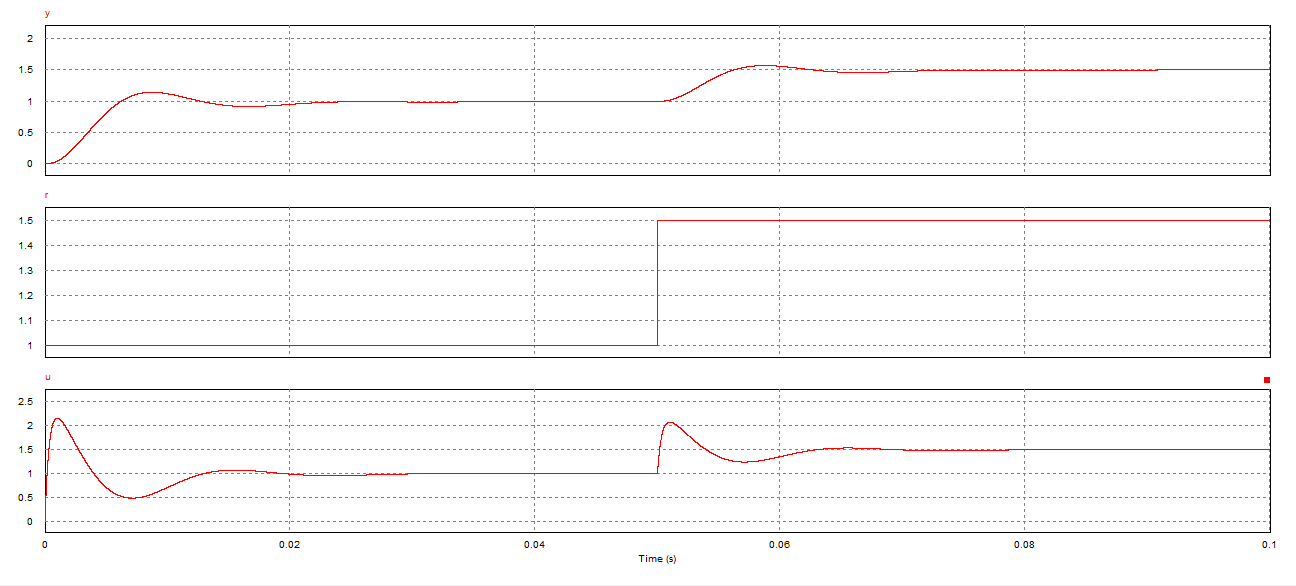

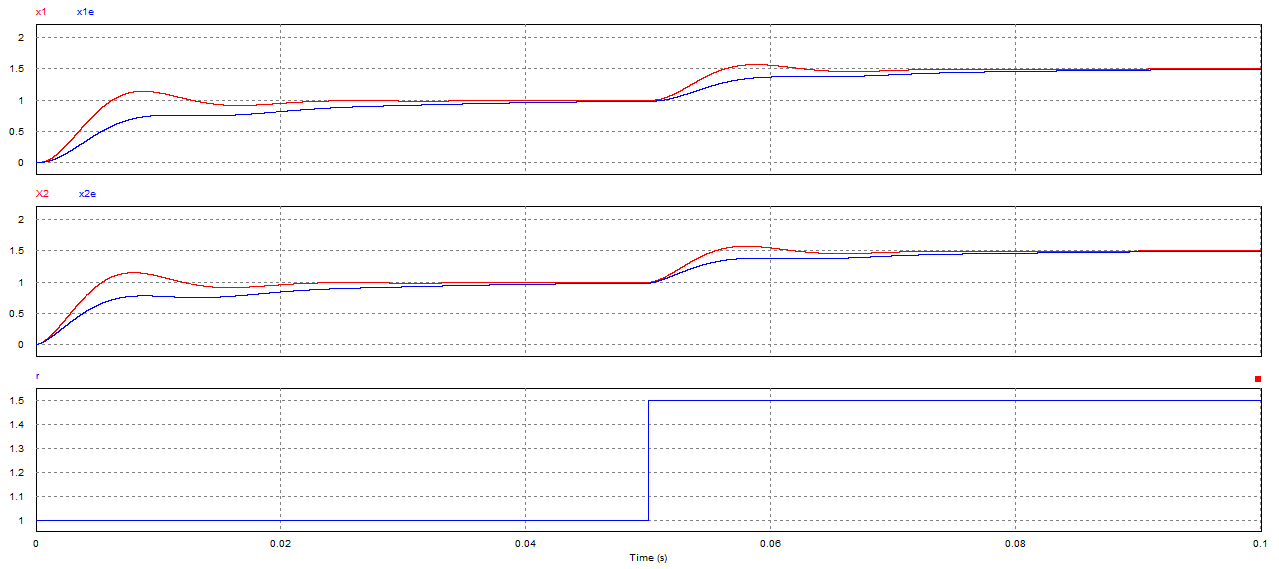

In [ ]:
Ts

0.00021

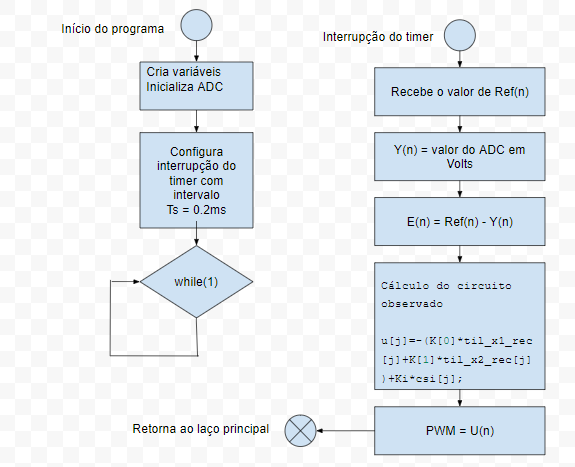